02. DETECTIONS TRACKING

In [1]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

import sys
sys.path.append(os.getenv("PROJECT_PATH"))

from inference import get_model
import supervision as sv

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/2'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)

FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

SOURCE_VIDEO_PATH = "../../data/videos/old10s.mp4"

C:\Users\pedro\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Supervision annotators
from utils.pitchconfig import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

#Supervision - virtualization
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

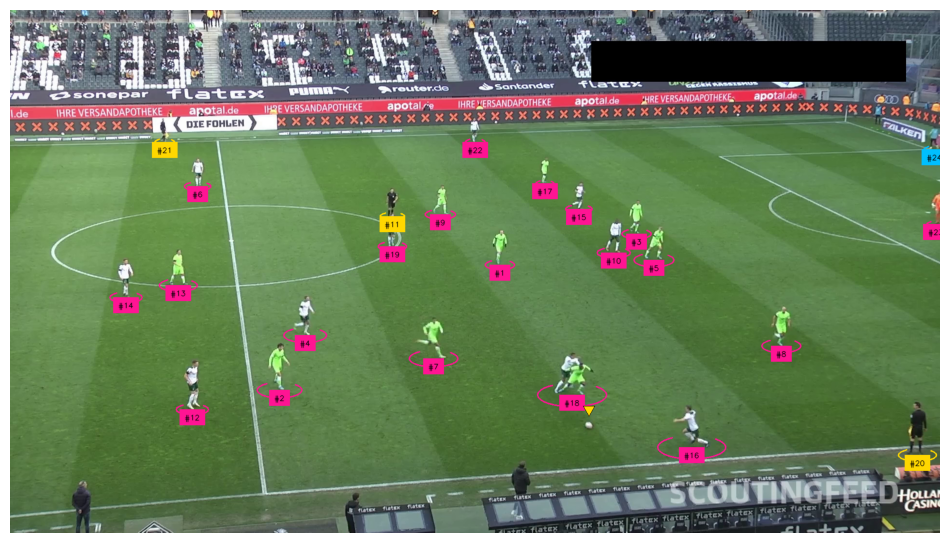

In [3]:
#Tracking IDs
BALL_ID = 0

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1 # remove ball class id
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [4]:
#Team Assignment based on colours
#use of the SigLIP, UMAP, and KMeans combo
import supervision as sv
from tqdm import tqdm
from utils.teamclassifier import TeamClassifier

PLAYER_ID = 2
STRIDE = 60
frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE
)

crops = []
for frame in tqdm(frame_generator, desc="collecting crops"):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    
    # Skip the frame if no players are detected
    if len(players_detections.xyxy) == 0:
        continue
    
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    crops += players_crops

# Ensure there are enough crops for clustering
if len(crops) < 2:
    print("Not enough player crops detected. Skipping team classification.")
else:
    team_classifier = TeamClassifier(device="cpu")
    team_classifier.fit(crops)
    
print(f"Number of players detected: {len(crops)}")

collecting crops: 5it [00:06,  1.36s/it]
Embedding extraction: 4it [00:36,  9.04s/it]


Number of players detected: 100


In [5]:
#GK Assignment - calculate avg centroid of players and assign GK to the team with the closest centroid
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Embedding extraction: 1it [00:06,  6.68s/it]


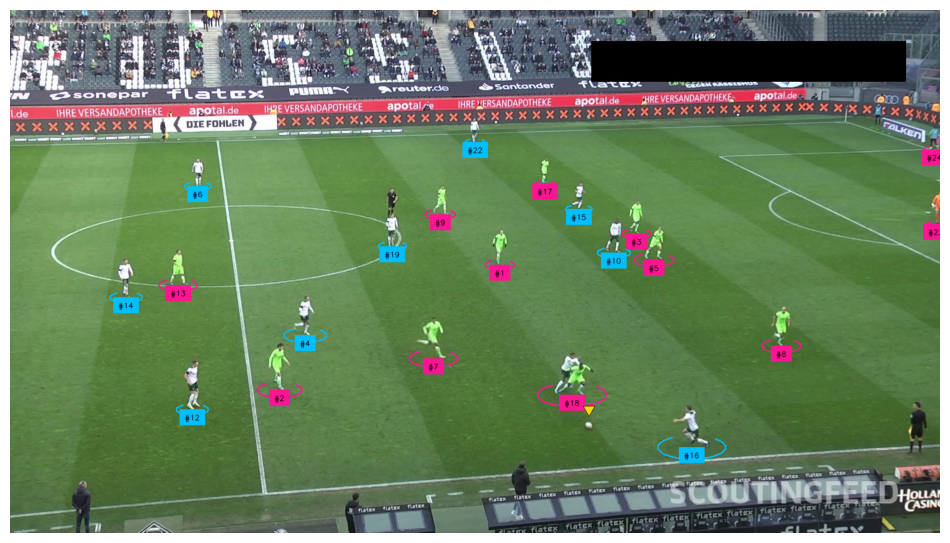

In [6]:
#Tracking with team assignment and gk assignment - 1 frame
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [7]:
#Frame collection for training
from tqdm import tqdm

frames = []

for frame_index, frame in enumerate(tqdm(sv.get_video_frames_generator(SOURCE_VIDEO_PATH), desc="Processing...")):
    if frame_index % 5 == 0: 
        frames.append(frame)

print(f"Total frames collected: {len(frames)}")

Processing...: 300it [00:04, 71.15it/s]


Total frames collected: 60


In [8]:
#Full tracking - All Frames
import supervision as sv
from utils.viewtransformer import ViewTransformer
from utils.drawpitch import draw_pitch, draw_points_on_pitch

pitch_frames = []
virt_frames = []

ball_coords = []
gk_t1_coords = []
gk_t2_coords = []

player_coords_per_id = dict()

# Tracker
tracker = sv.ByteTrack()

for frame_index, frame in enumerate(tqdm(frames, desc="Processing...")):
    tqdm.write(f"Frame {frame_index}")

    # ball, goalkeepers and players detections
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.2)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]

    # team assignment
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)
    
    all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

    # frame visualization
    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)

    pitch_frames.append(annotated_frame.copy())
    
    players_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections
    ])
    
    # detect pitch key points
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)
    
    # Ensure key_points is not None and contains valid data
    if key_points is None or key_points.confidence is None:
        print(f"Skipping frame {frame_index} due to missing key points.")
        continue  # Skip this frame and move to the next one

    # project ball, players and gk on pitch
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    # Ensure there are at least 4 points for homography calculation
    if len(frame_reference_points) < 4 or len(pitch_reference_points) < 4:
        print(f"Skipping frame due to insufficient keypoints: {len(frame_reference_points)} found.")
        continue  # Skip this frame and move to the next one

    # Proceed with homography calculation
    transformer = ViewTransformer(
        source = frame_reference_points,
        target = pitch_reference_points
    )

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = transformer.transform_points(points=players_xy)
    
    # --- Save player coordinates per ID in pitch space ---
    for idx, tracker_id in enumerate(players_detections.tracker_id):
        if tracker_id is not None:
            if tracker_id not in player_coords_per_id:
                player_coords_per_id[tracker_id] = []
            x, y = pitch_players_xy[idx]
            player_coords_per_id[tracker_id].append((frame_index, x, y))

    # --- Save ball coordinates in pitch space ---
    if len(pitch_ball_xy) > 0:
        x, y = pitch_ball_xy[0]
        ball_coords.append((frame_index, x, y))
    else:
        ball_coords.append((frame_index, None, None))

    # --- Save goalkeeper coordinates for each team in pitch space ---
    # Find goalkeepers in players_detections (merged with goalkeepers)
    gk_indices = np.where(players_detections.class_id == GOALKEEPER_ID)[0]
    for idx in gk_indices:
        x, y = pitch_players_xy[idx]
        # Use the original team assignment for GKs
        team_id = resolve_goalkeepers_team_id(players_detections, players_detections[idx:idx+1])[0]
        if team_id == 0:
            gk_t1_coords.append((frame_index, x, y))
        elif team_id == 1:
            gk_t2_coords.append((frame_index, x, y))
    
    # visualize video game-style radar view
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)

    virt_frames.append(annotated_frame.copy())  
    
    #tracker.reset()

Frame 0


Processing...:   0%|          | 0/60 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.87s/it]


Frame 1


Processing...:   2%|▏         | 1/60 [00:10<09:56, 10.11s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.43s/it]


Frame 2


Processing...:   3%|▎         | 2/60 [00:20<09:49, 10.16s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.75s/it]


Frame 3


Processing...:   5%|▌         | 3/60 [00:29<09:13,  9.71s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.23s/it]


Frame 4


Processing...:   7%|▋         | 4/60 [00:39<09:00,  9.65s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.18s/it]


Frame 5


Processing...:   8%|▊         | 5/60 [00:48<08:49,  9.63s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.72s/it]


Frame 6


Processing...:  10%|█         | 6/60 [00:57<08:34,  9.52s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.28s/it]


Frame 7


Processing...:  12%|█▏        | 7/60 [01:08<08:37,  9.76s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.05s/it]


Frame 8


Processing...:  13%|█▎        | 8/60 [01:19<08:48, 10.16s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.70s/it]


Frame 9


Processing...:  15%|█▌        | 9/60 [01:30<08:54, 10.48s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.58s/it]


Frame 10


Processing...:  17%|█▋        | 10/60 [01:41<08:46, 10.53s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.14s/it]


Frame 11


Processing...:  18%|█▊        | 11/60 [01:50<08:21, 10.24s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  6.00s/it]


Frame 12


Processing...:  20%|██        | 12/60 [01:59<07:53,  9.87s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.73s/it]


Frame 13


Processing...:  22%|██▏       | 13/60 [02:09<07:39,  9.79s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.76s/it]


Frame 14


Processing...:  23%|██▎       | 14/60 [02:19<07:40, 10.01s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.80s/it]


Frame 15


Processing...:  25%|██▌       | 15/60 [02:30<07:41, 10.26s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.54s/it]


Frame 16


Processing...:  27%|██▋       | 16/60 [02:42<07:50, 10.70s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:08,  8.07s/it]


Frame 17


Processing...:  28%|██▊       | 17/60 [02:54<07:53, 11.02s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.89s/it]


Frame 18


Processing...:  30%|███       | 18/60 [03:01<07:03, 10.07s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.56s/it]


Frame 19


Processing...:  32%|███▏      | 19/60 [03:09<06:16,  9.17s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.83s/it]


Frame 20


Processing...:  33%|███▎      | 20/60 [03:16<05:48,  8.70s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.94s/it]


Frame 21


Processing...:  35%|███▌      | 21/60 [03:24<05:28,  8.43s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.93s/it]


Frame 22


Processing...:  37%|███▋      | 22/60 [03:32<05:15,  8.29s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.71s/it]


Frame 23


Processing...:  38%|███▊      | 23/60 [03:40<05:06,  8.29s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.29s/it]


Frame 24


Processing...:  40%|████      | 24/60 [03:47<04:46,  7.96s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.09s/it]


Frame 25


Processing...:  42%|████▏     | 25/60 [03:54<04:28,  7.68s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.69s/it]


Frame 26


Processing...:  43%|████▎     | 26/60 [04:02<04:19,  7.62s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.26s/it]


Frame 27


Processing...:  45%|████▌     | 27/60 [04:11<04:25,  8.06s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.68s/it]


Frame 28


Processing...:  47%|████▋     | 28/60 [04:19<04:13,  7.92s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:01,  1.93s/it]


Frame 29


Processing...:  48%|████▊     | 29/60 [04:23<03:35,  6.95s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:02,  2.32s/it]


Frame 30


Processing...:  50%|█████     | 30/60 [04:29<03:14,  6.48s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.06s/it]


Frame 31


Processing...:  52%|█████▏    | 31/60 [04:35<03:06,  6.43s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.20s/it]


Frame 32


Processing...:  53%|█████▎    | 32/60 [04:41<02:58,  6.39s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.38s/it]


Frame 33


Processing...:  55%|█████▌    | 33/60 [04:48<02:52,  6.40s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.23s/it]


Frame 34


Processing...:  57%|█████▋    | 34/60 [04:55<02:52,  6.65s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.55s/it]


Frame 35


Processing...:  58%|█████▊    | 35/60 [05:03<02:56,  7.04s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.29s/it]


Frame 36


Processing...:  60%|██████    | 36/60 [05:12<03:02,  7.62s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.51s/it]


Frame 37


Processing...:  62%|██████▏   | 37/60 [05:24<03:25,  8.92s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:08,  8.64s/it]


Frame 38


Processing...:  63%|██████▎   | 38/60 [05:36<03:40, 10.03s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.63s/it]


Frame 39


Processing...:  65%|██████▌   | 39/60 [05:47<03:31, 10.09s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.87s/it]


Frame 40


Processing...:  67%|██████▋   | 40/60 [05:56<03:18,  9.93s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.63s/it]


Frame 41


Processing...:  68%|██████▊   | 41/60 [06:06<03:05,  9.76s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.76s/it]


Frame 42


Processing...:  70%|███████   | 42/60 [06:16<03:00, 10.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.98s/it]


Frame 43


Processing...:  72%|███████▏  | 43/60 [06:24<02:38,  9.33s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.38s/it]


Frame 44


Processing...:  73%|███████▎  | 44/60 [06:31<02:17,  8.61s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.45s/it]


Frame 45


Processing...:  75%|███████▌  | 45/60 [06:38<02:01,  8.12s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.31s/it]


Frame 46


Processing...:  77%|███████▋  | 46/60 [06:46<01:55,  8.24s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.42s/it]


Frame 47


Processing...:  78%|███████▊  | 47/60 [06:55<01:48,  8.34s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.38s/it]


Frame 48


Processing...:  80%|████████  | 48/60 [07:03<01:38,  8.22s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.26s/it]


Frame 49


Processing...:  82%|████████▏ | 49/60 [07:13<01:36,  8.79s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.03s/it]


Frame 50


Processing...:  83%|████████▎ | 50/60 [07:22<01:30,  9.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.99s/it]


Frame 51


Processing...:  85%|████████▌ | 51/60 [07:31<01:21,  9.02s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.32s/it]


Frame 52


Processing...:  87%|████████▋ | 52/60 [07:41<01:12,  9.12s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.89s/it]


Frame 53


Processing...:  88%|████████▊ | 53/60 [07:49<01:01,  8.80s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.11s/it]


Frame 54


Processing...:  90%|█████████ | 54/60 [07:58<00:53,  8.96s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.08s/it]


Frame 55


Processing...:  92%|█████████▏| 55/60 [08:08<00:46,  9.22s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.39s/it]


Frame 56


Processing...:  93%|█████████▎| 56/60 [08:18<00:37,  9.39s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.38s/it]


Frame 57


Processing...:  95%|█████████▌| 57/60 [08:26<00:27,  9.07s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.66s/it]


Frame 58


Processing...:  97%|█████████▋| 58/60 [08:36<00:18,  9.40s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.19s/it]


Frame 59


Processing...:  98%|█████████▊| 59/60 [08:46<00:09,  9.53s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.97s/it]
Processing...: 100%|██████████| 60/60 [08:57<00:00,  8.96s/it]


In [9]:
#Save frames with detections to folder
import cv2
import numpy as np

frames_len = len(frames)

output_dir = f"../../data/frames/old10s-{frames_len}f"
os.makedirs(output_dir, exist_ok=True)

for idx, frame in enumerate(pitch_frames):
    frame_path = os.path.join(output_dir, f"frame_{idx:04d}.png")
    
    cv2.imwrite(frame_path,np.array(frame))

In [11]:
#Save coordinates per frame to CSV
import csv
import numpy as np

output_csv_path = f"../../data/coords/old10s-{frames_len}f.csv" 
all_ids = sorted(player_coords_per_id.keys())

# Build lookups
frame_lookup = {}
for tracker_id, coords in player_coords_per_id.items():
    for frame_index, x, y in coords:
        if frame_index not in frame_lookup:
            frame_lookup[frame_index] = {}
        frame_lookup[frame_index][tracker_id] = [x, y]

ball_lookup = {f: [x, y] for f, x, y in ball_coords}
gk0_lookup = {f: [x, y] for f, x, y in gk_t1_coords}
gk1_lookup = {f: [x, y] for f, x, y in gk_t2_coords}

header = (
    ["frame_index", "ball", "gk0", "gk1"] +
    [f"id_{id}" for id in all_ids]
)

all_frames = sorted(set(
    list(frame_lookup.keys()) +
    list(ball_lookup.keys()) +
    list(gk0_lookup.keys()) +
    list(gk1_lookup.keys())
))

with open(output_csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for frame_index in all_frames:
        row = [frame_index]
        # Ball
        ball = ball_lookup.get(frame_index, None)
        if ball and None not in ball:
            row.append(f"[{ball[0]:.2f},{ball[1]:.2f}]")
        else:
            row.append("")
        # GK team 0
        gk0 = gk0_lookup.get(frame_index, None)
        if gk0 and None not in gk0:
            row.append(f"[{gk0[0]:.2f},{gk0[1]:.2f}]")
        else:
            row.append("")
        # GK team 1
        gk1 = gk1_lookup.get(frame_index, None)
        if gk1 and None not in gk1:
            row.append(f"[{gk1[0]:.2f},{gk1[1]:.2f}]")
        else:
            row.append("")
        # Players by id
        for id in all_ids:
            coord = frame_lookup.get(frame_index, {}).get(id, None)
            if coord and None not in coord:
                row.append(f"[{coord[0]:.2f};{coord[1]:.2f}]")
            else:
                row.append("")
        writer.writerow(row)

print(f"Coordinates per frame saved to {output_csv_path}")

Coordinates per frame saved to ../../data/coords/old10s-60f.csv
